In [1]:
import os
import cv2 as cv
import numpy as np
import ipynb.fs.defs.Utils as Utils
import ipynb.fs.defs.FeatureMatching as FeatureMatching
import ipynb.fs.defs.GraphBuilding as GraphBuilding
import ipynb.fs.defs.BasicStitching as BasicStitching
import ipynb.fs.defs.SimpleGraphStitching as SimpleGraphStitching
import ipynb.fs.defs.MultiGraphStitching as MultiGraphStitching
import ipynb.fs.defs.MultiPatchStitching as MultiPatchStitching
import ipynb.fs.defs.Benchmark as Benchmark

In [2]:
#Directories
dataset_name = 'sun'
dataset_dir = f'datasets/{dataset_name}'
stitching_dir = "stitched"
partial_results_dir = "partial"

In [3]:
#global variables
save_output = True
save_images = True
simple_output_dir ="output_simple"
average_output_dir ="output_average"
multi_output_dir ="output_multi"
results_dir = "results"
verbose = False
noisy_matching = True
results = list()

In [4]:
#graph parameters
matching_threshold = 0.7
number_of_matches = 1
noise_std = 0.01
matches_th = 30
RANSACmaxIters = 1000

In [5]:
#general stitching parameters
idx_ref = None
idxs = None
beautify = True
warp_shape = [10000,10000]

In [6]:
#basic stitching parameters
basic_stitching_dir = "basic_stitching"
#simple graph stitching parameters
simple_graph_stitching_dir = "simple_graph"
#simple graph stitching parameters
edge_averaging_stitching_dir = "edge_averaging"
#multigraph stitching parameters
multi_graph_stitching_dir = "multi_graph"
#multipatch stitching parameters
multi_patch_stitching_dir = "multi_patch"
#edge averaging patch stitching parameters
average_patch_stitching_dir = "average_patch"

In [7]:
#Load images from the folder
imgs = Utils.load_images_from_folder(dataset_dir)

In [8]:
#compute normalization matrices
T_norm = Utils.get_normalization_matrix(imgs)

In [9]:
#verify if single graph matrices are already computed, otherwise compute them
matches_dict, weight_matrix = FeatureMatching.get_feature_matches(dataset_name,
            imgs,
            T_norm,
            matching_threshold = matching_threshold,
            number_of_matches = number_of_matches,
            noise_std = noise_std,
            matches_th = matches_th,
            RANSACmaxIters = RANSACmaxIters,
            save_output = save_output,
            save_images = save_images,
            output_dir = simple_output_dir,
            results_dir = results_dir,
            noisy_matching = noisy_matching,
            verbose = verbose
           )

In [10]:
M, Z, adj_matrix = GraphBuilding.build_simple_graph_matrices(dataset_name,
            imgs,
            matches_dict,
            output_dir = simple_output_dir,
            verbose = verbose,
            save_output = save_output
           )

M_average, Z_average, adj_matrix_average = GraphBuilding.build_edge_averaging_matrices(dataset_name,
            imgs,
            matches_dict,
            output_dir = average_output_dir,
            verbose = verbose,
            save_output = save_output
           )

M_multi, Z_multi, C_multi, adj_matrix_multi = GraphBuilding.build_multi_graph_matrices(dataset_name,
            imgs,
            matches_dict,
            output_dir = multi_output_dir,
            verbose = verbose,
            save_output = save_output
           )

In [11]:
if idx_ref is None:
    idx_ref = Utils.get_reference_node(adj_matrix)

In [12]:
#basic stitching without synchronization
H_basic, basic_stitched_image = BasicStitching.basic_stitching(dataset_name,
                            imgs,
                            T_norm,
                            Z, 
                            adj_matrix, 
                            weight_matrix,
                            idx_ref = idx_ref,
                            verbose = verbose,
                            save_output = save_output,
                            beautify = beautify,
                            stitching_dir = stitching_dir,
                            partial_results_dir = partial_results_dir,
                            basic_stitching_dir = basic_stitching_dir,
                            warp_shape = warp_shape
                            )
results.append({"name":"Basic Stitching","H":H_basic,"img":basic_stitched_image})

In [13]:
H_simple_graph, simple_graph_stitched_image = SimpleGraphStitching.simple_graph_stitching(dataset_name,
                            imgs,
                            T_norm,
                            M, 
                            idx_ref = idx_ref,
                            idxs = idxs,
                            verbose = verbose,
                            save_output = save_output,
                            beautify = beautify,
                            stitching_dir = stitching_dir,
                            graph_stitching_dir = simple_graph_stitching_dir,
                            warp_shape = warp_shape )
results.append({"name":"Simple Graph Stitching","H":H_simple_graph,"img":simple_graph_stitched_image})

In [14]:
H_average, edge_averaging_stitched_image = SimpleGraphStitching.simple_graph_stitching(dataset_name,
                            imgs,
                            T_norm,
                            M_average, 
                            idx_ref = idx_ref,
                            idxs = idxs,
                            verbose = verbose,
                            save_output = save_output,
                            beautify = beautify,
                            stitching_dir = stitching_dir,
                            graph_stitching_dir = edge_averaging_stitching_dir,
                            warp_shape = warp_shape )
results.append({"name":"Edge Averaging Stitching","H":H_average,"img":edge_averaging_stitched_image})

In [15]:
H_multi_graph, multi_graph_stitched_image = MultiGraphStitching.multi_graph_stitching(dataset_name,
                            imgs,
                            T_norm,
                            M_multi, 
                            C_multi,
                            idx_ref = idx_ref,
                            idxs = idxs,
                            verbose = verbose,
                            save_output = save_output,
                            beautify = beautify,
                            stitching_dir = stitching_dir,
                            graph_stitching_dir = multi_graph_stitching_dir,
                            warp_shape = warp_shape )
results.append({"name":"Multi-Graph Stitching","H":H_multi_graph,"img":multi_graph_stitched_image})

In [16]:
H_patch_graph, multi_patch_stitched_image = MultiPatchStitching.multi_patch_stitching(dataset_name,
                            imgs,
                            T_norm,
                            Z, #Matrix containing the homographies between images
                            adj_matrix, #Adjacency matrix of the graph built according to the matches between the images
                            weight_matrix, #Weight matrix of the graph built according to the matches between the images
                            verbose = verbose,
                            idx_ref = idx_ref,
                            save_output = save_output,
                            beautify = beautify,
                            stitching_dir = stitching_dir,
                            graph_stitching_dir = multi_patch_stitching_dir,
                            warp_shape = warp_shape )
results.append({"name":"Multi-Patch Stitching","H":H_patch_graph,"img":multi_patch_stitched_image})

In [17]:
H_patch_graph, average_patch_stitched_image = MultiPatchStitching.average_patch_stitching(dataset_name,
                            imgs,
                            T_norm,
                            Z, #Matrix containing the homographies between images
                            adj_matrix, #Adjacency matrix of the graph built according to the matches between the images
                            weight_matrix, #Weight matrix of the graph built according to the matches between the images
                            verbose = verbose,
                            idx_ref = idx_ref,
                            save_output = save_output,
                            beautify = beautify,
                            stitching_dir = stitching_dir,
                            graph_stitching_dir = average_patch_stitching_dir,
                            warp_shape = warp_shape )
results.append({"name":"Multi-Patch Edge Averaging Stitching","H":H_patch_graph,"img":average_patch_stitched_image})

## Benchmark

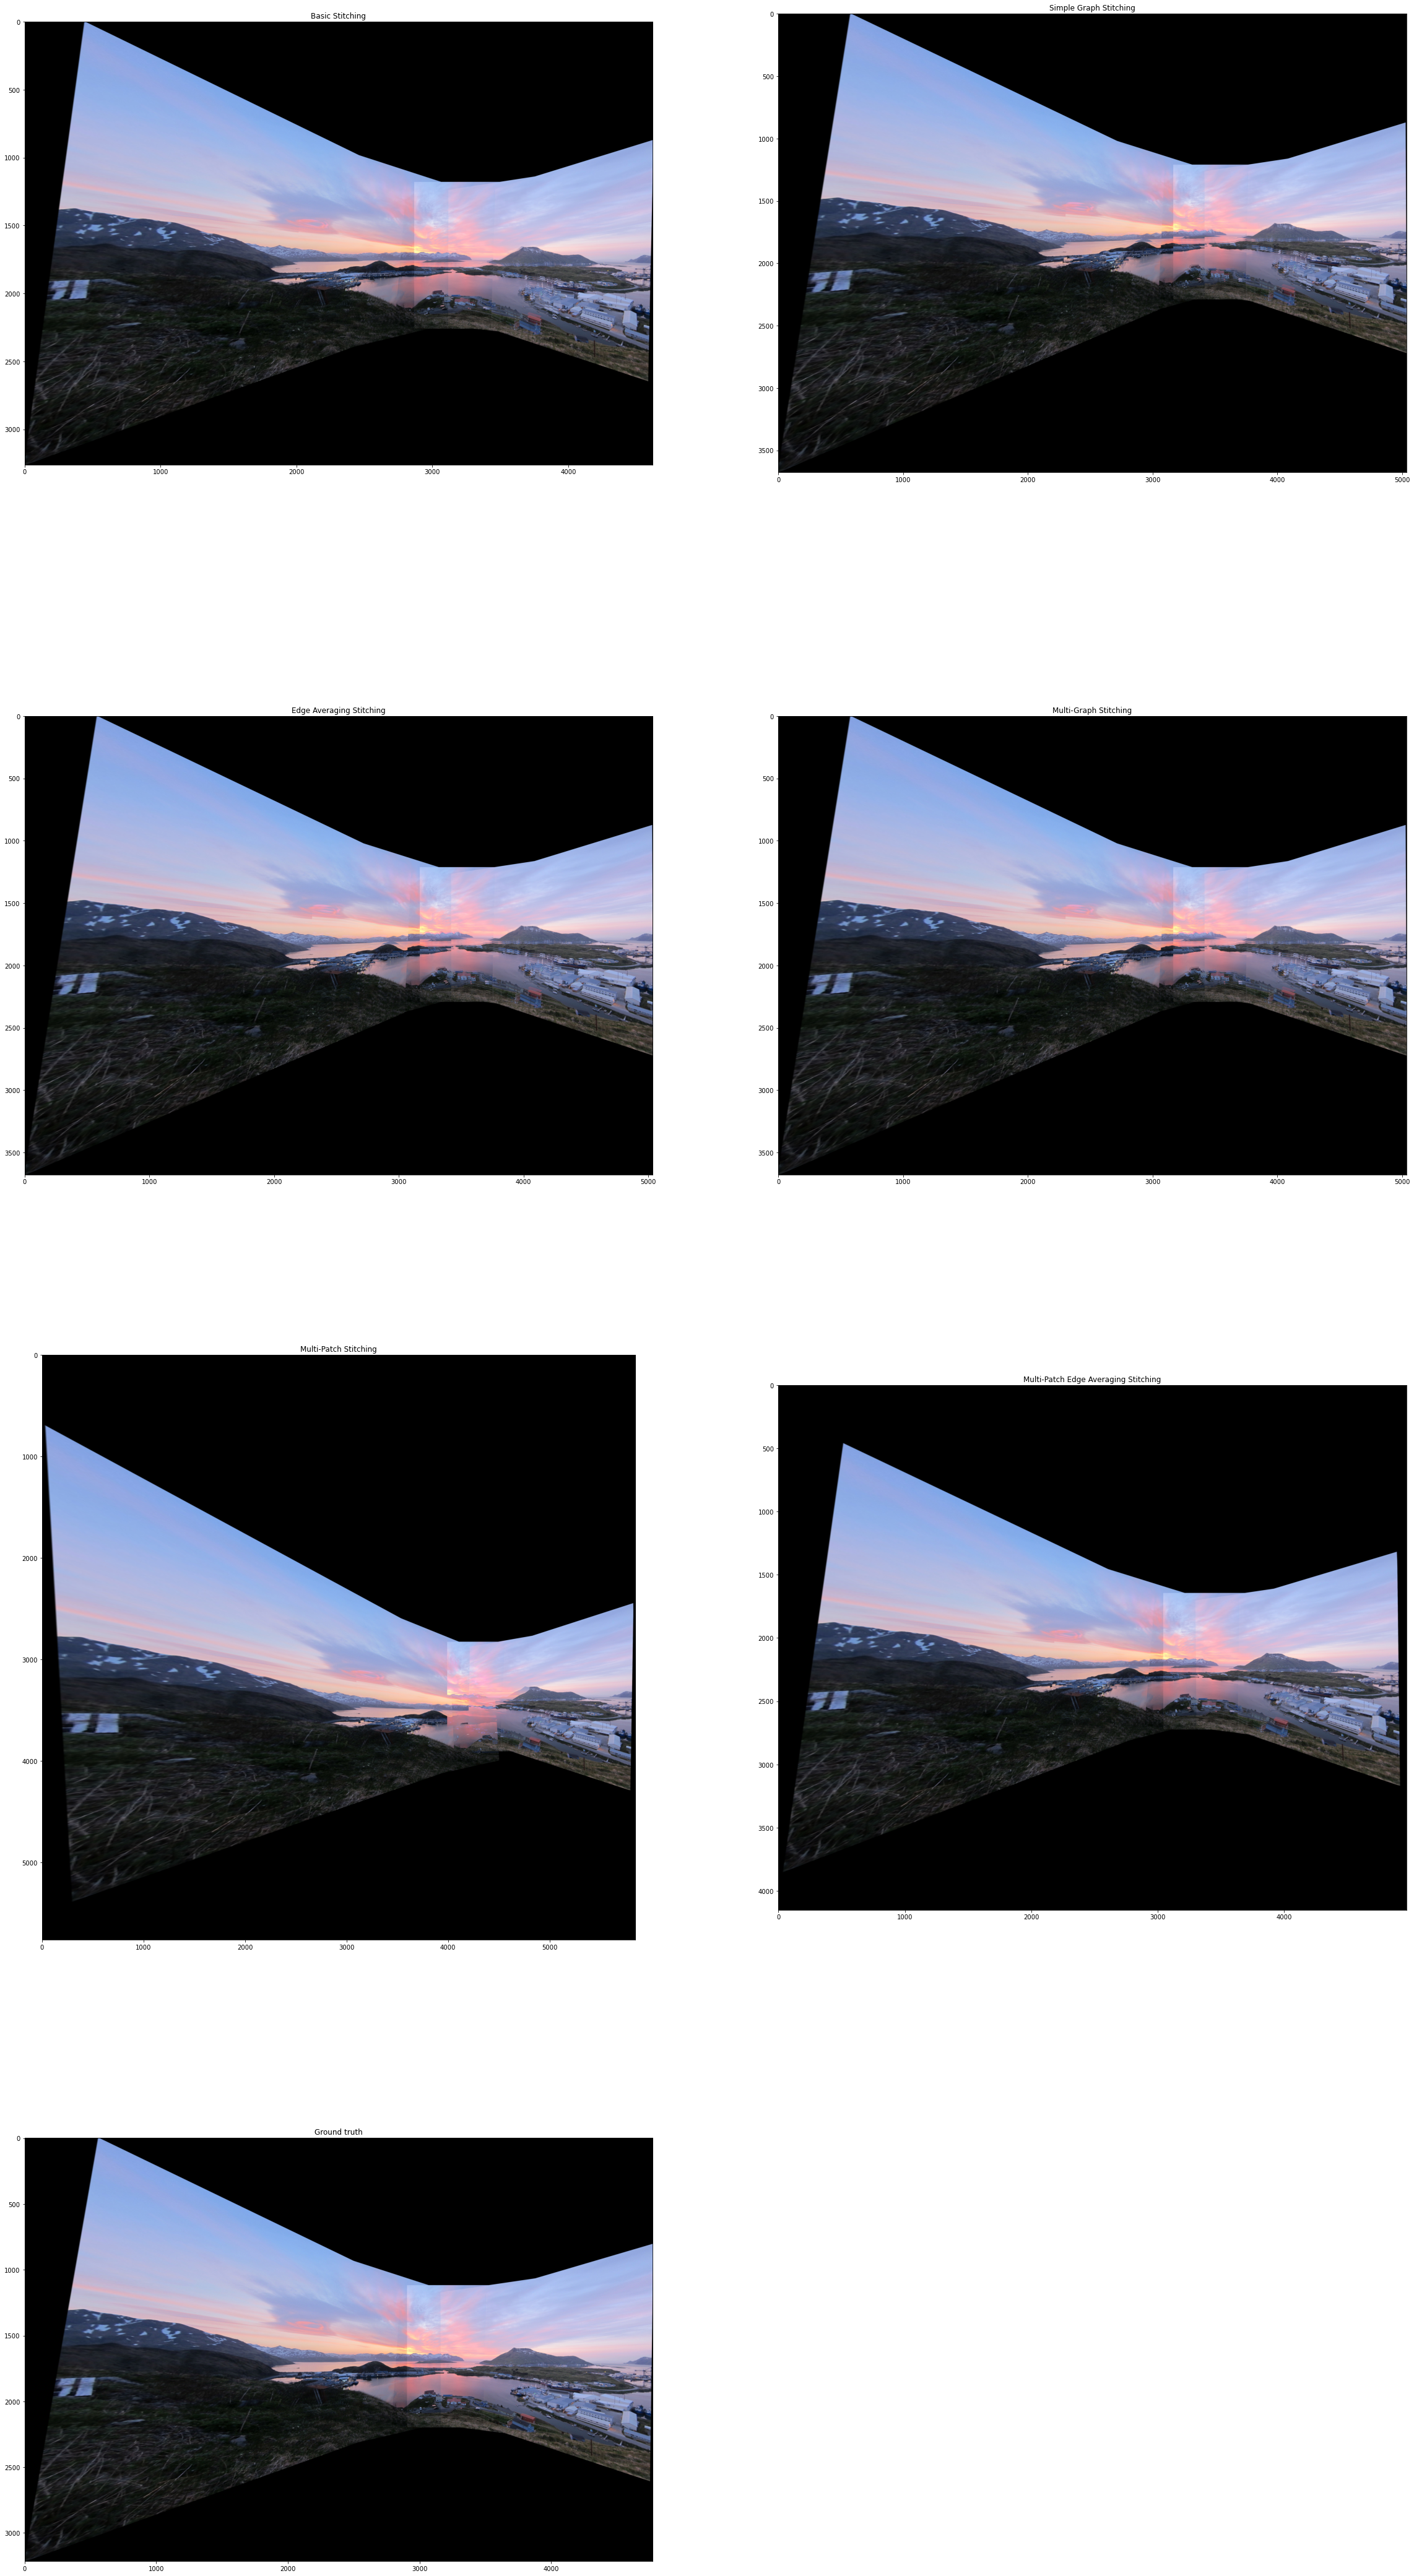

Basic Stitching  Simple Graph Stitching  \
number_of_matches noise_std                                            
1                 0.00              2.897775            4.025170e-16   
                  0.04              2.839618            9.681395e-01   
                  0.08              2.960060            2.172362e+00   
                  0.12              2.682019            3.866670e+00   
                  0.16              3.167270            6.933311e+00   
                  0.20              3.675739            1.220441e+02   
                  0.24              4.011198            2.833376e+00   
5                 0.00              2.897775            4.025170e-16   
                  0.04              2.798592            6.412049e-01   
                  0.08              3.136490            3.869145e-01   
                  0.12              3.098488            4.211655e+00   
                  0.16              3.389239            1.807240e+00   
                  0.20              3.077196            3.631938e+00   
                  0.24              3.274900            3.914421e+01   
10                0.00              2.897775            4.025170e-16   
                  0.04              2.813509            3.901479e-01   
                  0.08              2.981047            3.977906e+00   
                  0.12              2.978010            8.142663e+00   
                  0.16              3.027260            5.152711e+00   
                  0.20              3.855605            8.618677e+00   
                  0.24              3.813125            1.150644e+00   
15                0.00              2.897775            4.025170e-16   
                  0.04              2.884802            5.796154e-01   
                  0.08              2.933673            9.907342e-01   
                  0.12              2.958957            7.633926e-01   
                  0.16              2.852883            3.564836e+00   
                  0.20              3.297558            1.273477e+01   
                  0.24              4.409866            2.962301e+00   
20                0.00              2.897775            4.025170e-16   
                  0.04              2.980195            1.025142e+01   
                  0.08              2.985388            8.525309e-01   
                  0.12              3.085622            2.523174e+00   
                  0.16              2.460405            2.283734e+00   
                  0.20              4.086070            8.406353e-01   
                  0.24              3.106441            4.013760e+00   
25                0.00              2.897775            4.025170e-16   
                  0.04              2.895615            8.212692e-01   
                  0.08              2.877081            5.931968e-01   
                  0.12              2.961480            8.870364e-01   
                  0.16              3.424477            1.033486e+00   
                  0.20              3.057862            5.273986e+00   
                  0.24              3.112373            1.838385e+03   
30                0.00              2.897775            4.025170e-16   
                  0.04              2.873138            1.035864e+00   
                  0.08              2.761667            8.644695e+00   
                  0.12              3.409413            3.223991e+00   
                  0.16              3.144719            3.134986e+00   
                  0.20              2.798895            3.030743e+01   
                  0.24              3.323781            1.841197e+00   
1                 0.01              2.901740            2.062854e-01   

                             Edge Averaging Stitching  Multi-Graph Stitching  \
number_of_matches noise_std                                                    
1                 0.00                   4.025170e-16           4.113208e-14   
                  0.04                   9.6

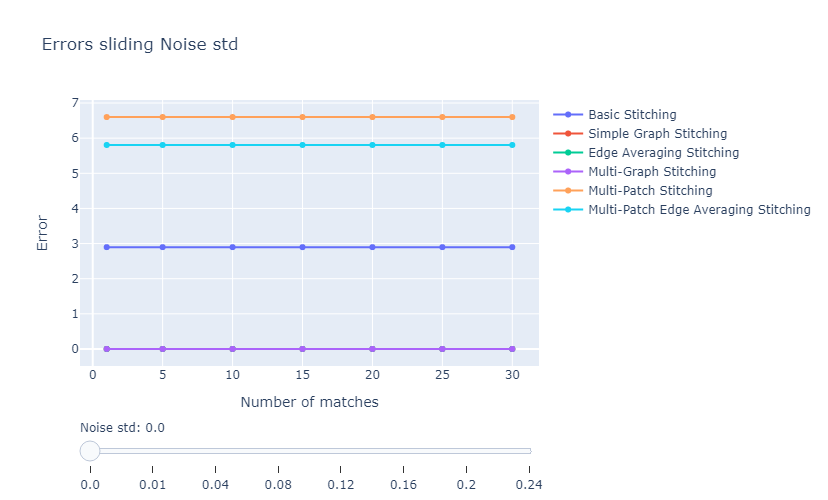

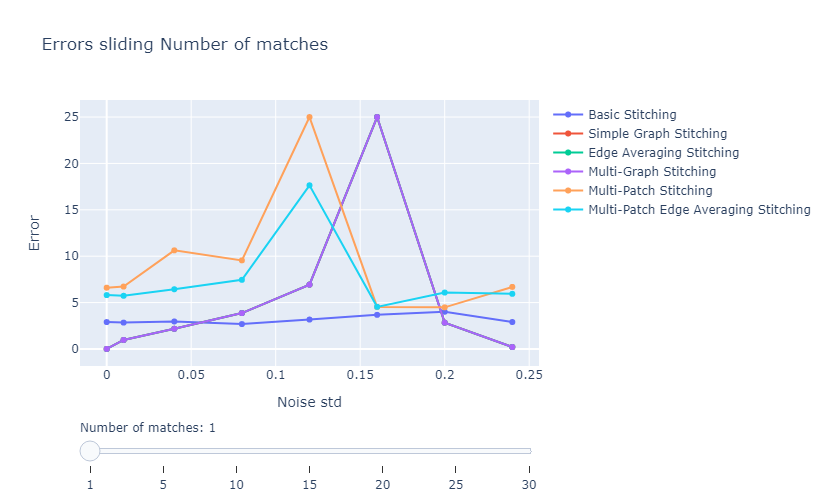

ValueError: cannot reshape array of size 50 into shape (8,7)

In [18]:
if noisy_matching:
    Benchmark.run_benchmark(dataset_name,
                                imgs,
                                T_norm = T_norm,
                                matching_threshold = matching_threshold,
                                matches_th = matches_th,
                                idx_ref = idx_ref,
                                results = results,
                                number_of_matches = number_of_matches,
                                noise_std = noise_std)